In [26]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ticker = "BTC-USD"        #using bitcoin here
start, end = "2020-01-01", "2025-05-28"

In [3]:
df = yf.download(ticker, start=start, end=end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1) #flatten dataframe

In [5]:
print("Columns:", df.columns.tolist())
df.head()

Columns: ['Close', 'High', 'Low', 'Open', 'Volume']


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


In [6]:
df["Return1"] = df['Close'].pct_change() #captures daily momentum
df["MA5"]     = df['Close'].rolling(5).mean() #takes the average of the last 5 closing prices
df["MA10"]    = df['Close'].rolling(10).mean() #takes the average of the last 10 closing prices
df["VolChg"]  = df["Volume"].pct_change() #computes the day‑to‑day percentage change in trading volume

In [7]:
df = df.dropna()

In [8]:
df = df.copy()

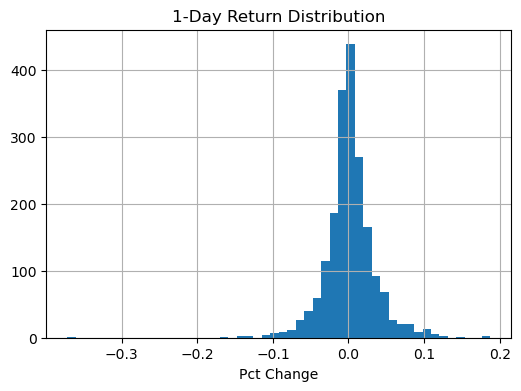

In [9]:
plt.figure(figsize=(6,4))
df["Return1"].hist(bins=50)
plt.title("1‑Day Return Distribution")
plt.xlabel("Pct Change")
plt.show()

- Plots a histogram of the `Return1` feature, i.e. the one‑day percentage change in closing price.  
- Uses 50 bins to show how frequently different levels of daily return occur. 
- The bulk of the bars sits tightly around **0%**, meaning most days see very small moves.  
- The distribution is roughly **bell‑shaped** but with **fat tails** (visible at ±10–20%), indicating occasional large jumps up or down.  
- A few extreme bars at the far left (e.g. –30%) or right (+15%) show rare but significant price swings—these outlier days can be the hardest for a model to predict accurately.  
- Understanding this shape tells us how “risky” the classification problem is: if almost every day is close to 0%, a naive model might do well by just predicting “no change,” but those fat‑tail days could dominate your error if they occur in your test set. 

In [10]:
from sklearn.model_selection import train_test_split

# 3.1 Next‑day up/down label
df["Target"] = (df['Close'].shift(-1) > df['Close']).astype(int)
df = df.dropna(subset=["Target"])

# 3.2 Define features & split (no shuffle)
features = ["Return1", "MA5", "MA10", "VolChg"]
X, y = df[features], df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

- Looks one day ahead (shift(-1)) and compares tomorrow’s close to today’s.
- Encodes 1 if the price goes up, 0 otherwise.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 4.1 Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 4.2 Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

print("\nRandom Forest")
print("Accuracy:", accuracy_score(y_test, y_rf))
print(classification_report(y_test, y_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_rf))

Logistic Regression
Accuracy: 0.5012722646310432
              precision    recall  f1-score   support

           0       0.50      0.96      0.65       193
           1       0.61      0.06      0.10       200

    accuracy                           0.50       393
   macro avg       0.55      0.51      0.38       393
weighted avg       0.55      0.50      0.37       393

Confusion Matrix:
 [[186   7]
 [189  11]]

Random Forest
Accuracy: 0.5267175572519084
              precision    recall  f1-score   support

           0       0.51      0.81      0.63       193
           1       0.58      0.25      0.35       200

    accuracy                           0.53       393
   macro avg       0.55      0.53      0.49       393
weighted avg       0.55      0.53      0.49       393

Confusion Matrix:
 [[157  36]
 [150  50]]


**How to interpret the results**  

1. **Logistic Regression**  
   - **Accuracy ~ 0.50**: only slightly better than random guessing (which would be 50% if classes are balanced).  
   - **Precision / Recall**:  
     - Class 0 (“down”): precision 0.50, recall 0.96 → almost every actual “down” day is caught (few false negatives), but half of “down” predictions are wrong.  
     - Class 1 (“up”): precision 0.61, recall 0.06 → when it calls “up,” it’s right 61% of the time, but it misses 94% of actual up‑moves (very low recall).  
   - **Confusion Matrix**  
     ```
     [[186   7]   ← predicted “down”: 186 TN, 7 FP  
      [189  11]]  ← predicted “up”  : 189 FN, 11 TP
     ```
     Most errors are **false negatives** (missed up‑days).

2. **Random Forest**  
   - **Accuracy ~ 0.53**: a modest bump over logistic regression.  
   - **Precision / Recall**:  
     - Class 0: precision 0.51, recall 0.81 → catches 81% of actual down‑days, with half of “down” calls correct.  
     - Class 1: precision 0.58, recall 0.25 → better at finding up‑days than LR (recall up from 0.06 → 0.25), but still misses most.  
   - **Confusion Matrix**  
     ```
     [[157 36]   ← 157 TN, 36 FP  
      [150 50]]  ← 150 FN, 50 TP
     ```
     Errors are more balanced: it still misses many up‑days, but raises true positives from 11→50.

---

**Key takeaways**  
- Both models struggle to reliably predict rare or volatile “up” days—our features may be too simplistic.  
- **Random Forest** improves recall on up‑days at the cost of more false positives.  
- **Next steps**:  
  - Enrich features (RSI, MACD, Bollinger Bands, sentiment scores)  
  - Try methods to handle class imbalance (e.g. SMOTE, class weights)  
  - Hyperparameter tuning (GridSearchCV)  
  - Walk‑forward cross‑validation to better simulate a live trading environment  

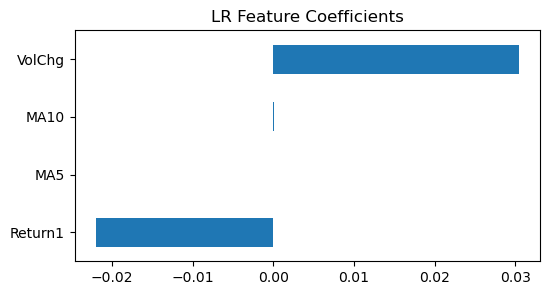

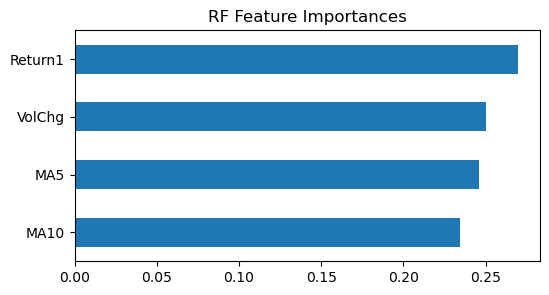

In [12]:
# LR coefficients
coeffs = pd.Series(lr.coef_[0], index=features).sort_values()
plt.figure(figsize=(6,3))
coeffs.plot.barh()
plt.title("LR Feature Coefficients")
plt.show()

# RF feature importances
imps = pd.Series(rf.feature_importances_, index=features).sort_values()
plt.figure(figsize=(6,3))
imps.plot.barh()
plt.title("RF Feature Importances")
plt.show()


LR Feature Coefficients

VolChg (volume change) has the largest positive coefficient (~+0.03), meaning days with rising volume are more likely to be labeled “up.”

Return1 (previous day’s return) has a negative coefficient (~–0.015), suggesting slight mean‑reversion—after a big up‑day, the model tilts toward predicting a down‑day.

MA5 and MA10 coefficients hover around zero, indicating these moving averages added little linear predictive power in this simple setup.

RF Feature Importances

All four features contribute roughly equally (each ~0.20–0.28), with Return1 slightly leading.

This tells us the random forest used a mix of momentum (returns), trend (MAs), and volume signals rather than over‑relying on a single indicator.

Key takeaway

Volume change is the strongest single linear predictor, but in a tree‑based model all features play a substantial role.

The negative LR weight on yesterday’s return hints at mean‑reversion, while the forest’s more balanced importances suggest it captures a combination of momentum and trend signals.